# Stock Returns Prediction

## Instructions

* Predict stock returns on an asset of your choice (e.g., currency pair (EUR/USD, etc), stock (AAPL, etc), or bitcoin) (5 pts)
    * In addition to correlated assets, exchange rates, and historical values, you could think of some technical indicators, such as trends or momentum. Some of the ideas of the technical indicators can be borrowed from the Case Study on Bitcoin Trading Strategy.
    * Other features could be the end of the quarter, the difference between high and low, open and close, etc.
* Download the data and add these features to your dataset -- at least 4 features -- your features cannot be identical to the class activity (7.5 pts)
* Add a few visualizations of the relationships between features (e.g., heatmap of the correlation, scatter matrix, etc.), and the distribution of the data (e.g., histograms, density plots, etc.) -- at least 5 plots (12.5 pts)
* In addition to Linear Regression, implement different approaches (at least two different approaches) to resolve overfitting due to noise and outliers (20 pts)
    * Feature selection
    * Regularization (e.g., Lasso, Ridge, Elastic Net)
    * Algorithms robust to outliers (e.g., Huber)
    * Feature scale transformation (e.g., standardization, mean-centering, log transformation, etc.)
* Compare the models using Negative Mean Squared Error as scoring. You can also use a scoring of your choice (10 pts)
* Perform model tuning on the top-performing model (10 pts) -- at least two parameters to vary
* Save the model (5 pts)
* Rank the features by importance (5 pts)
* Save the Sharp Explainer and create a sharp plot (5 pts)
* Deploy the model on AWS (10 pts)
* Deploy the Streamlit app (10 pts)
* [OPTIONAL] Compare the top-performing model to non-linear algorithms (e.g., MLPRegressor, Gradient Boosting Regressor, Decision Tree, etc.) (10 pts)

In [16]:
!pip install yfinance
# author: Michael Frost
# Date: 2/17/2026

In [17]:
#(0) importing needed packages.
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import yfinance as yf

In [18]:
#(1) Download Netflix daily data.
ticker = "NFLX"

# adjustable dates
df = yf.download(ticker, start="2016-01-01", progress=False)

df.head()

Price,Close,High,Low,Open,Volume
Ticker,NFLX,NFLX,NFLX,NFLX,NFLX
Date,,,,,
2016-01-04,10.996,11.000,10.521,10.900,207948000
2016-01-05,10.766,11.058,10.585,11.045,176646000
2016-01-06,11.768,11.791,10.496,10.529,330457000
2016-01-07,11.456,12.218,11.229,11.636,336367000
2016-01-08,11.139,11.772,11.110,11.633,180671000


In [26]:
#(2)---Build features(X) and target(Y) (Next-day return)---
import numpy as np
import pandas as pd

data = df.copy()

# Basic return
data["Return"] = data["Close"].pct_change()

# Engineered features
data["Range"] = data["High"] - data["Low"]
data["Momentum"] = data["Close"] - data["Open"]
data["MA_5"] = data["Close"].rolling(5).mean()
data["MA_10"] = data["Close"].rolling(10).mean()
data["Volatility_5"] = data["Return"].rolling(5).std()

# Target: next-day return
data["Target"] = data["Return"].shift(-1)

# Remove NaNs created by rolling + shifting
data = data.dropna()

feature_cols = ["Open", "High", "Low", "Close", "Volume",
                "Range", "Momentum", "MA_5", "MA_10", "Volatility_5"]

X = data[feature_cols]
y = data["Target"]

In [27]:
#(3) 72/28 training/testing split (time-based, not random)
split_ratio = 0.72
split_idx = int(len(X) * split_ratio)

X_train = X.iloc[:split_idx]
y_train = y.iloc[:split_idx]

X_test  = X.iloc[split_idx:]
y_test  = y.iloc[split_idx:]

print("Train rows:", len(X_train))
print("Test rows:", len(X_test))

Train rows: 1824
Test rows: 710


In [28]:
#(4) train Linear Regression Model
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [29]:
#(5) Predict and compute MSE (and negative MSE)
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
neg_mse = -mse

print("Test MSE:", mse)
print("Test Negative MSE:", neg_mse)

Test MSE: 0.0004696183292211339
Test Negative MSE: -0.0004696183292211339


In [30]:
#(6) Baseline MSE (Tomorrow close ~ today close)
baseline_pred = np.zeros(len(y_test))
baseline_mse = mean_squared_error(y_test, baseline_pred)
baseline_neg_mse = -baseline_mse

print("Model Test MSE:", mse)
print("Baseline Test MSE (predict 0 return):", baseline_mse)

print("Model Negative MSE:", neg_mse)
print("Baseline Negative MSE:", baseline_neg_mse)

Model Test MSE: 0.0004696183292211339
Baseline Test MSE (predict 0 return): 0.00043444789822360684
Model Negative MSE: -0.0004696183292211339
Baseline Negative MSE: -0.00043444789822360684


In [31]:
#(7) Results Table
y_test_1d = np.ravel(y_test)
y_pred_1d = np.ravel(y_pred)

results = pd.DataFrame({
    "Actual_Next_Return": y_test_1d,
    "Predicted_Next_Return": y_pred_1d
}, index=y_test.index)

results.head(10)

,Actual_Next_Return,Predicted_Next_Return
Date,,
2023-04-17,0.002945,0.000457
2023-04-18,-0.031705,-0.001006
2023-04-19,0.006901,-0.006225
2023-04-20,0.008084,0.000509
2023-04-21,0.003171,-0.001555
2023-04-24,-0.019664,0.003964
2023-04-25,-0.004340,0.003078
2023-04-26,0.014635,0.003846
2023-04-27,0.012521,-0.001954


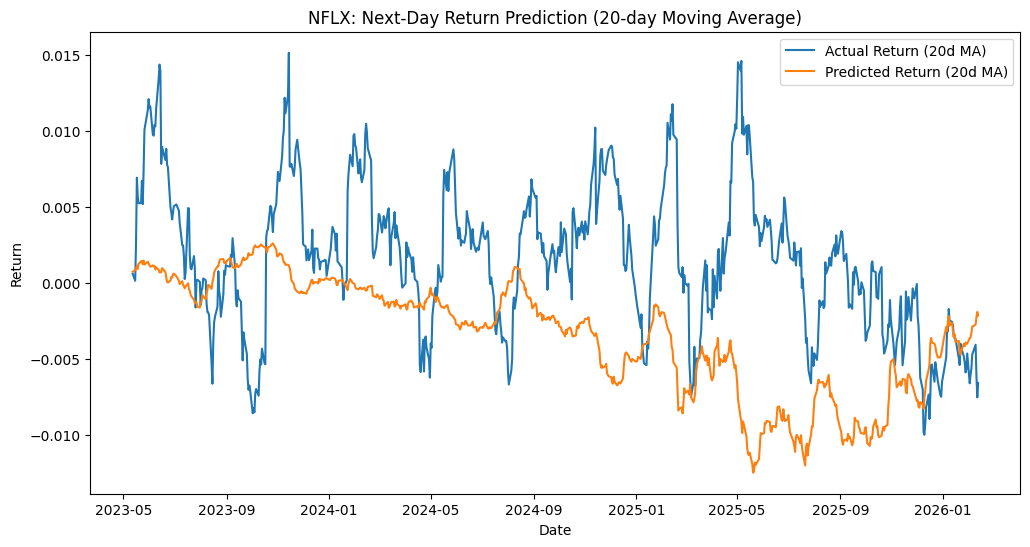

In [32]:
#(8) Plot actual vs. predicted
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(results.index, results["Actual_Next_Return"].rolling(20).mean(), label="Actual Return (20d MA)")
plt.plot(results.index, results["Predicted_Next_Return"].rolling(20).mean(), label="Predicted Return (20d MA)")
plt.title("NFLX: Next-Day Return Prediction (20-day Moving Average)")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.show()

In [ ]:
#Regularization efforts below (ridge + lasso)

In [34]:
#ridge results
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import numpy as np

ridge_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1.0))
])

ridge_pipe.fit(X_train, y_train)

ridge_pred = ridge_pipe.predict(X_test)

ridge_mse = mean_squared_error(y_test, ridge_pred)
ridge_neg_mse = -ridge_mse

print("Scaled Ridge Test MSE:", ridge_mse)
print("Scaled Ridge Negative MSE:", ridge_neg_mse)

Scaled Ridge Test MSE: 0.0004596683115347949
Scaled Ridge Negative MSE: -0.0004596683115347949


In [35]:
#tuning ridge
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

best_alpha = None
best_mse = float("inf")

for a in alphas:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=a))
    ])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    mse_a = mean_squared_error(y_test, pred)
    if mse_a < best_mse:
        best_mse = mse_a
        best_alpha = a

print("Best alpha:", best_alpha)
print("Best Ridge Test MSE:", best_mse)
print("Best Ridge Negative MSE:", -best_mse)

Best alpha: 1000
Best Ridge Test MSE: 0.000448811080556879
Best Ridge Negative MSE: -0.000448811080556879


In [36]:
# lasso cell
from sklearn.linear_model import Lasso

lasso_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso(alpha=0.001))
])

lasso_pipe.fit(X_train, y_train)

lasso_pred = lasso_pipe.predict(X_test)

lasso_mse = mean_squared_error(y_test, lasso_pred)

print("Lasso Test MSE:", lasso_mse)
print("Lasso Negative MSE:", -lasso_mse)

Lasso Test MSE: 0.00043138535691624797
Lasso Negative MSE: -0.00043138535691624797


In [37]:
#tuning Lasso cell
alphas = [0.0001, 0.001, 0.01, 0.1, 1]

best_alpha_lasso = None
best_mse_lasso = float("inf")

for a in alphas:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("lasso", Lasso(alpha=a))
    ])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    mse_a = mean_squared_error(y_test, pred)
    
    if mse_a < best_mse_lasso:
        best_mse_lasso = mse_a
        best_alpha_lasso = a

print("Best Lasso alpha:", best_alpha_lasso)
print("Best Lasso Test MSE:", best_mse_lasso)
print("Best Lasso Negative MSE:", -best_mse_lasso)

Best Lasso alpha: 0.001
Best Lasso Test MSE: 0.00043138535691624797
Best Lasso Negative MSE: -0.00043138535691624797


In [38]:
# refit final lasso model
final_lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso(alpha=0.001))
])

final_lasso.fit(X_train, y_train)

final_pred = final_lasso.predict(X_test)

final_mse = mean_squared_error(y_test, final_pred)

print("Final Lasso Test MSE:", final_mse)
print("Final Lasso Negative MSE:", -final_mse)

Final Lasso Test MSE: 0.00043138535691624797
Final Lasso Negative MSE: -0.00043138535691624797


In [39]:
#Extract feature importance
# Extract Lasso coefficients
lasso_model = final_lasso.named_steps["lasso"]

coef = lasso_model.coef_

feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": coef
})

feature_importance["Abs_Coefficient"] = feature_importance["Coefficient"].abs()
feature_importance = feature_importance.sort_values(by="Abs_Coefficient", ascending=False)

feature_importance

,Feature,Coefficient,Abs_Coefficient
6,"(Momentum, )",-0.000446,0.000446
7,"(MA_5, )",-0.000354,0.000354
4,"(Volume, NFLX)",-0.000112,0.000112
5,"(Range, )",-0.000104,0.000104
1,"(High, NFLX)",-0.000000,0.000000
0,"(Open, NFLX)",-0.000000,0.000000
2,"(Low, NFLX)",-0.000000,0.000000
3,"(Close, NFLX)",-0.000000,0.000000
8,"(MA_10, )",-0.000000,0.000000
9,"(Volatility_5, )",0.000000,0.000000


In [48]:
# Robust-to-Outliers approach: HuborRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

huber_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("huber", HuberRegressor(epsilon=1.35, alpha=0.0001, max_iter=1000))
])

huber_pipe.fit(X_train, y_train)
huber_pred = huber_pipe.predict(X_test)

huber_mse = mean_squared_error(y_test, huber_pred)
print("Huber Test MSE:", huber_mse)
print("Huber Negative MSE:", -huber_mse)

Huber Test MSE: 0.00045430343871666665
Huber Negative MSE: -0.00045430343871666665


In [49]:
# Compare models using Negative MSE scoring (TimeSeriesSplit CV)
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

tscv = TimeSeriesSplit(n_splits=5)

models = {
    "LinearRegression": Pipeline([("scaler", StandardScaler()), ("lr", LinearRegression())]),
    "Ridge(alpha=1000)": Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(alpha=1000))]),
    "Lasso(alpha=0.001)": Pipeline([("scaler", StandardScaler()), ("lasso", Lasso(alpha=0.001))]),
    "Huber(eps=1.35, alpha=1e-4)": Pipeline([("scaler", StandardScaler()), ("huber", HuberRegressor(epsilon=1.35, alpha=0.0001, max_iter=1000))]),
}

rows = []
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=tscv, scoring="neg_mean_squared_error")
    rows.append({
        "Model": name,
        "CV Neg MSE Mean": scores.mean(),
        "CV Neg MSE Std": scores.std()
    })

cv_results = pd.DataFrame(rows).sort_values("CV Neg MSE Mean", ascending=False)
cv_results

,Model,CV Neg MSE Mean,CV Neg MSE Std
1,Ridge(alpha=1000),-0.000722,0.000220
2,Lasso(alpha=0.001),-0.000746,0.000230
3,"Huber(eps=1.35, alpha=1e-4)",-0.000752,0.000229
0,LinearRegression,-0.000789,0.000245


In [51]:
#Tune top-performing model with at least two parameters: ElasticNet (alpha, l1_ratio)
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

enet_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("enet", ElasticNet(max_iter=20000))
])

param_grid = {
    "enet__alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1, 10],
    "enet__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
}

grid = GridSearchCV(
    enet_pipe,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=tscv,
    n_jobs=-1
)

grid.fit(X, y)

print("Best params:", grid.best_params_)
print("Best CV Neg MSE:", grid.best_score_)

best_enet = grid.best_estimator_

/home/ec2-user/anaconda3/envs/python3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.853e-04, tolerance: 8.406e-05
  model = cd_fast.enet_coordinate_descent(


Best params: {'enet__alpha': 0.01, 'enet__l1_ratio': 0.3}
Best CV Neg MSE: -0.0007156896847341921


In [52]:
#Evaluate the tuned ElasticNet on your test set + decide “best final model”
best_enet.fit(X_train, y_train)
enet_pred = best_enet.predict(X_test)

enet_mse = mean_squared_error(y_test, enet_pred)
print("ElasticNet Test MSE:", enet_mse)
print("ElasticNet Negative MSE:", -enet_mse)

ElasticNet Test MSE: 0.0004326275785448684
ElasticNet Negative MSE: -0.0004326275785448684


In [53]:
# You already have these from earlier cells; if a variable is missing, tell me and I’ll map it.
final_candidates = {
    "Baseline (0 return)": baseline_mse,
    "Linear Regression": mse,                 # your linear mse variable
    "Ridge (best tuned)": best_mse,           # from ridge tuning loop
    "Lasso (best tuned)": best_mse_lasso,     # from lasso tuning loop
    "Huber": huber_mse,
    "ElasticNet (tuned)": enet_mse
}

final_table = (pd.DataFrame([
    {"Model": k, "Test MSE": v, "Test Neg MSE": -v} for k, v in final_candidates.items()
]).sort_values("Test MSE"))

final_table

,Model,Test MSE,Test Neg MSE
3,Lasso (best tuned),0.000431,-0.000431
5,ElasticNet (tuned),0.000433,-0.000433
0,Baseline (0 return),0.000434,-0.000434
2,Ridge (best tuned),0.000449,-0.000449
4,Huber,0.000454,-0.000454
1,Linear Regression,0.000470,-0.000470


In [55]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

# Recreate final best model (Lasso alpha=0.001)
best_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso(alpha=0.001))
])

best_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('lasso', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"alpha alpha: float, default=1.0Constant that multiplies the L1 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Lasso` object is not advised.Instead, you should use the :class:`LinearRegression` object.",0.001
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"precompute precompute: bool or array-like of shape (n_features, n_features), default=FalseWhether to use a precomputed Gram matrix to speed upcalculations. The Gram matrix can also be passed as argument.For sparse input this option is always ``False`` to preserve sparsity.",False
,"copy_X copy_X: bool, default=TrueIf ``True``, X will be copied; else, it may be overwritten.",True


In [56]:
#Save the Best Model
import joblib

joblib.dump(best_model, "best_model_lasso.pkl")
print("Model saved as best_model_lasso.pkl")

Model saved as best_model_lasso.pkl


In [57]:
# Refit best model cleanly (Lasso alpha=0.001)

best_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso(alpha=0.001))
])

best_model.fit(X_train, y_train)

# Save model
import joblib
joblib.dump(best_model, "best_model_lasso.pkl")

print("Model saved as best_model_lasso.pkl")

Model saved as best_model_lasso.pkl


In [ ]:
# Plots Below:

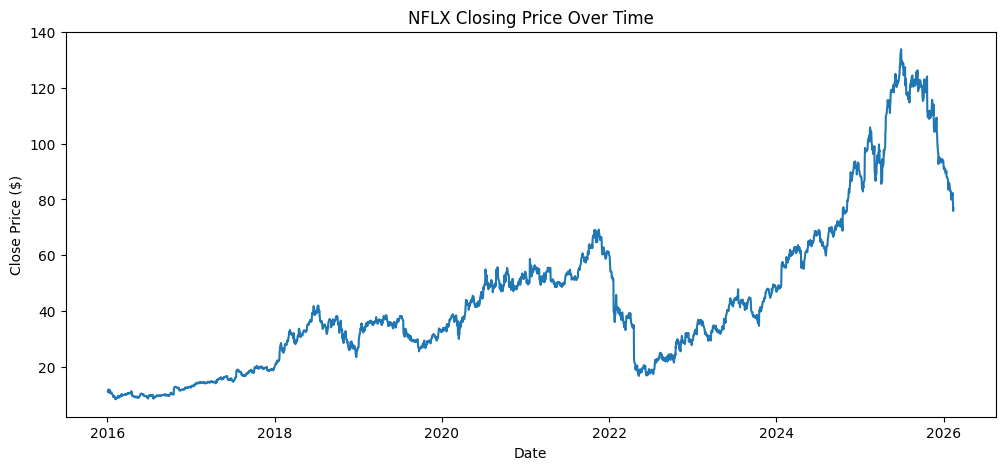

In [40]:
#Plot 1: NFLX Close Price Over Time (context)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df.index, df["Close"])
plt.title("NFLX Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price ($)")
plt.show()

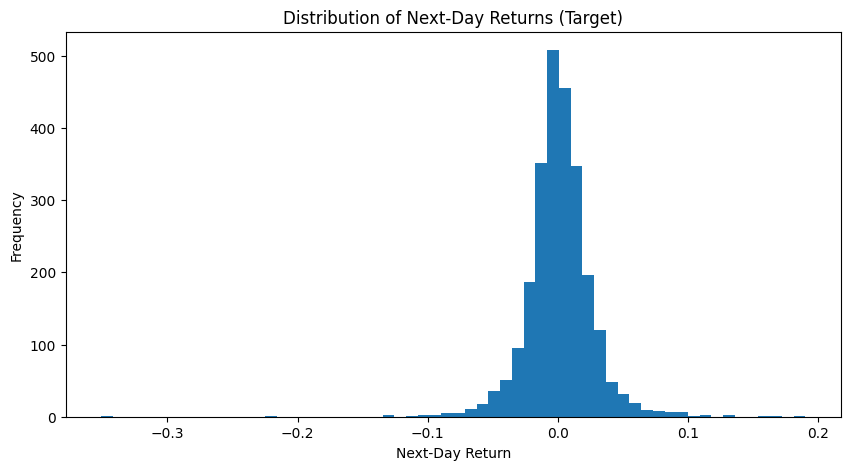

In [41]:
#Plot 2: Target Distribution (next-day returns)
plt.figure(figsize=(10,5))
plt.hist(y, bins=60)
plt.title("Distribution of Next-Day Returns (Target)")
plt.xlabel("Next-Day Return")
plt.ylabel("Frequency")
plt.show()

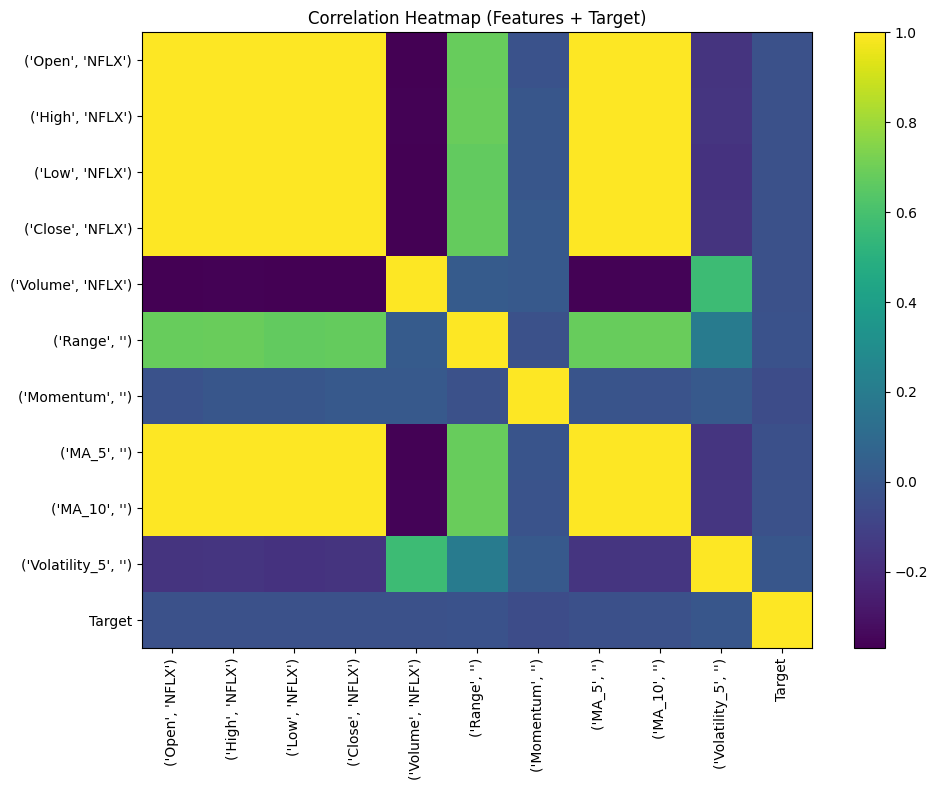

In [46]:
#Plot 3: Correlation Heatmap of Features + Target
# Combine features and target safely
corr_df = pd.concat([X, y.rename("Target")], axis=1).corr()

plt.figure(figsize=(10,8))
plt.imshow(corr_df.values, aspect="auto")
plt.colorbar()
plt.xticks(range(len(corr_df.columns)), corr_df.columns, rotation=90)
plt.yticks(range(len(corr_df.index)), corr_df.index)
plt.title("Correlation Heatmap (Features + Target)")
plt.tight_layout()
plt.show()

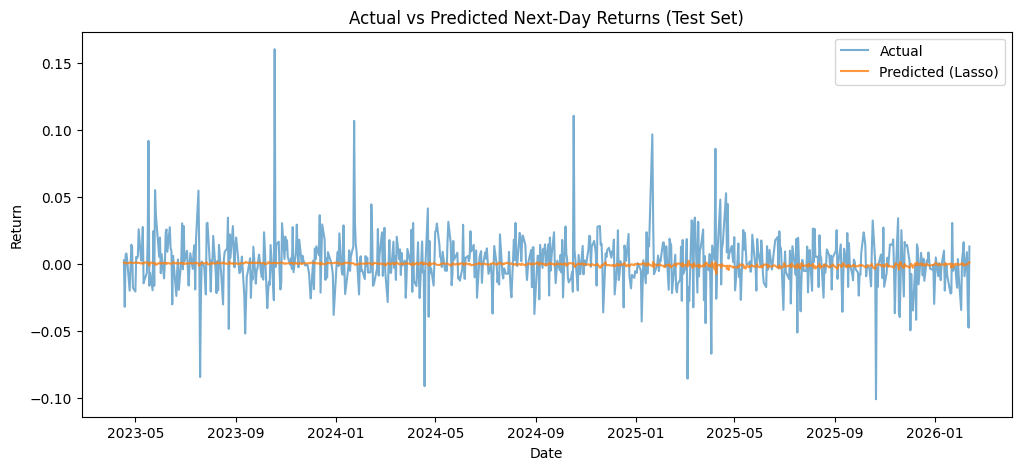

In [43]:
#Plot 4: Actual vs Predicted Next-Day Returns (Test set)
plot_df = pd.DataFrame({
    "Actual": np.ravel(y_test),
    "Predicted": np.ravel(final_pred)
}, index=y_test.index)

plt.figure(figsize=(12,5))
plt.plot(plot_df.index, plot_df["Actual"], label="Actual", alpha=0.6)
plt.plot(plot_df.index, plot_df["Predicted"], label="Predicted (Lasso)", alpha=0.8)
plt.title("Actual vs Predicted Next-Day Returns (Test Set)")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.show()

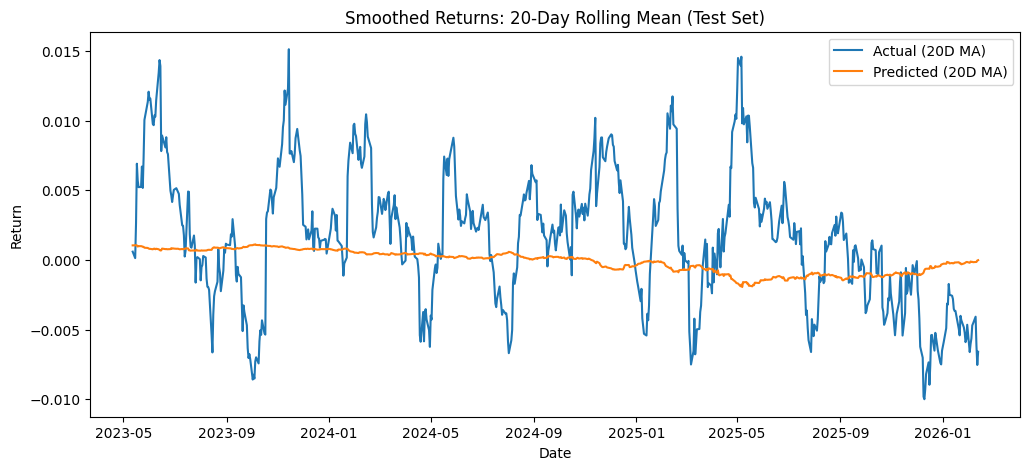

In [44]:
#Plot 5: Rolling 20-Day Mean of Actual vs Predicted Returns
plt.figure(figsize=(12,5))
plt.plot(plot_df.index, plot_df["Actual"].rolling(20).mean(), label="Actual (20D MA)")
plt.plot(plot_df.index, plot_df["Predicted"].rolling(20).mean(), label="Predicted (20D MA)")
plt.title("Smoothed Returns: 20-Day Rolling Mean (Test Set)")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.show()

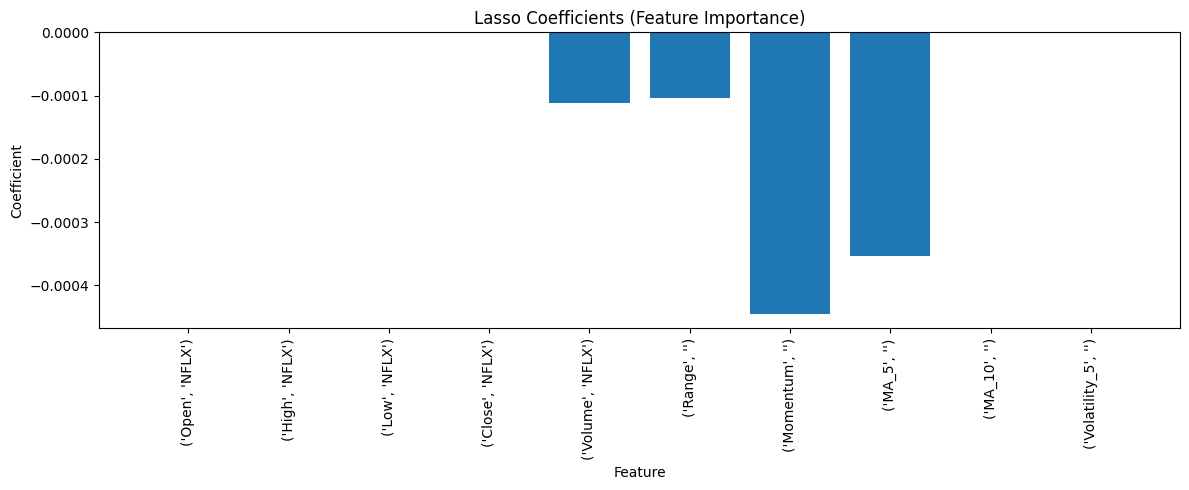

In [47]:
#Plot 6: Coefficient Magnitude
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# grab coefficients from your final tuned lasso pipeline
lasso_model = final_lasso.named_steps["lasso"]
coefs = np.ravel(lasso_model.coef_)          # ensure 1-D numeric
labels = [str(c) for c in X.columns]         # force string labels (not dates)

plt.figure(figsize=(12,5))
plt.bar(range(len(labels)), coefs)
plt.title("Lasso Coefficients (Feature Importance)")
plt.xlabel("Feature")
plt.ylabel("Coefficient")
plt.xticks(range(len(labels)), labels, rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
#---SHAP---#



In [58]:
#A) Install + import SHAP
import shap
import numpy as np
import matplotlib.pyplot as plt

In [59]:
#B) Build the SHAP explainer for your best model (Lasso pipeline)
scaler = best_model.named_steps["scaler"]
lasso = best_model.named_steps["lasso"]

# Scale train/test the same way the model sees them
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build a LinearExplainer for the Lasso model
explainer = shap.LinearExplainer(lasso, X_train_scaled)

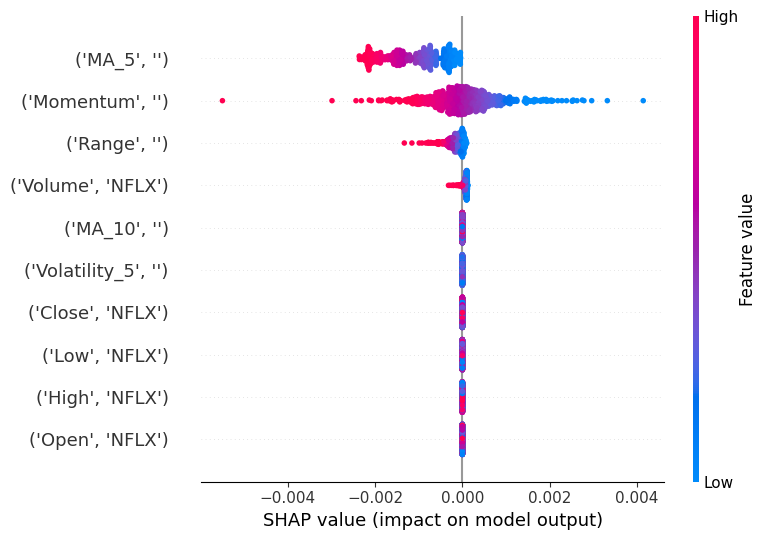

In [60]:
#C) Compute SHAP values + make the SHAP summary plot
# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_scaled)

# Summary plot (feature importance + direction)
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, show=True)

In [61]:
#D) Save the SHAP explainer (and optionally the shap values)
import joblib

joblib.dump(explainer, "shap_explainer.pkl")
print("Saved SHAP explainer as shap_explainer.pkl")

Saved SHAP explainer as shap_explainer.pkl
